## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from best_pipelines import models_to_cv
from preproc import PhishingDatasetPreproc

## Setup

In [3]:
np.random.seed(42)

In [4]:
prep = PhishingDatasetPreproc()
dataset, X, y = prep.basic_operations()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [5]:
best_pipelines, ensembles = models_to_cv()

In [6]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.pipeline import Pipeline, make_pipeline
import statistics as st
from imblearn.over_sampling import ADASYN

def stress_testing(X_train, y_train, X_test, y_test, pipelines, use_adasyn=False):
    if use_adasyn == True:
            adasyn = ADASYN(sampling_strategy='auto', random_state=42)
            X_train, y_train = adasyn.fit_resample(X_train, y_train)
            
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    # Lists to store the metrics
    test_metrics = {
        'model_name': [],
        'ACSA': [],
        'recall': [],
        'CM': [],
        'f1_score': [],
        'training_time': [],
        'inference_time': [],
        'error_rate': [],
        'train_accuracy': [],
        'test_accuracy': [],
        'precision': [],
    }

    for model_name, pipeline in pipelines.items():
        print(f'Model {model_name}')

        start_train = time.time()
        fitted_model = pipeline.fit(X_train, y_train)
        stop_train = time.time()
        training_time = stop_train - start_train

        # Train and test predictions
        y_train_pred = fitted_model.predict(X_train)
        start_test = time.time()
        y_test_pred = fitted_model.predict(X_test)
        stop_test = time.time()
        inference_time = stop_test - start_test

        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        prec = precision_score(y_test, y_test_pred)
        rec = recall_score(y_test, y_test_pred)
        error_rate = 1 - test_accuracy  # Error rate is 1 - accuracy
        rec = recall_score(y_test, y_test_pred)
        conf_matrix = confusion_matrix(y_test, y_test_pred)
        class_accuracies = np.diag(conf_matrix) / conf_matrix.sum(axis=1)
        acsa = class_accuracies.mean()

        # Storing metrics
        test_metrics['train_accuracy'].append(train_accuracy)
        test_metrics['test_accuracy'].append(test_accuracy)
        test_metrics['f1_score'].append(f1)
        test_metrics['precision'].append(prec)
        test_metrics['error_rate'].append(error_rate)
        test_metrics['recall'].append(rec)
        test_metrics['model_name'].append(model_name)
        test_metrics['ACSA'].append(acsa)
        test_metrics['CM'].append(conf_matrix)
        test_metrics['training_time'].append(training_time)
        test_metrics['inference_time'].append(inference_time)
                    
    metrics = pd.DataFrame(test_metrics)

    if use_adasyn == True:
        metrics.to_csv(f'../metrics/metrics_stress_test_adasyn.csv', index=False)
    else:
        metrics.to_csv(f'../metrics/metrics_stress_test.csv', index=False)

    print(f'\n Metrics: \n{metrics}')
    
    return metrics

In [7]:
best_pipelines.update(ensembles)

In [8]:
best_pipelines

{'KNN': Pipeline(steps=[('selector',
                  SelectFromModel(estimator=LogisticRegression(C=0.335,
                                                               penalty='l1',
                                                               solver='liblinear'))),
                 ('model',
                  KNeighborsClassifier(metric='manhattan', weights='distance'))]),
 'LVQ': Pipeline(steps=[('selector', PCA(n_components=25)),
                 ('model', LVQ(epochs=20, lrate=0.24, n_codebooks=15))]),
 'DTR': Pipeline(steps=[('selector',
                  SelectFromModel(estimator=RandomForestClassifier(n_estimators=112))),
                 ('model',
                  DecisionTreeClassifier(criterion='entropy', max_depth=11,
                                         max_features='log2', min_samples_leaf=2,
                                         min_samples_split=4,
                                         splitter='random'))]),
 'SVM': Pipeline(steps=[('scaler', StandardScale

# No adasyn

In [9]:
test_metrics_no_adasyn = stress_testing(X_train, y_train, X_test, y_test, best_pipelines, use_adasyn=False)
test_metrics_no_adasyn 

Model KNN
Model LVQ
Model DTR
Model SVM


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Model RF
Model XGB
Model LGBM


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 227, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, clo

[LightGBM] [Info] Number of positive: 4576, number of negative: 3715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 8291, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551924 -> initscore=0.208447
[LightGBM] [Info] Start training from score 0.208447
Model MLP
Model Heterogêneo
Model ANNs

 Metrics: 
    model_name      ACSA    recall                         CM  f1_score  \
0          KNN  0.951433  0.967109   [[1107, 76], [52, 1529]]  0.959824   
1          LVQ  0.864925  0.941176   [[933, 250], [93, 1488]]  0.896656   
2          DTR  0.937281  0.960784  [[1081, 102], [62, 1519]]  0.948782   
3          SVM  0.948578  0.969007   [[1098, 85], [49, 1532]]  0.958099   
4           RF  0.96071

,model_name,ACSA,recall,CM,f1_score,training_time,inference_time,error_rate,train_accuracy,test_accuracy,precision
0,KNN,0.951433,0.967109,"[[1107, 76], [52, 1529]]",0.959824,0.073509,0.406408,0.046310,0.989145,0.953690,0.952648
1,LVQ,0.864925,0.941176,"[[933, 250], [93, 1488]]",0.896656,9.774213,0.134066,0.124096,0.882885,0.875904,0.856157
2,DTR,0.937281,0.960784,"[[1081, 102], [62, 1519]]",0.948782,0.325415,0.000552,0.059334,0.938126,0.940666,0.937076
3,SVM,0.948578,0.969007,"[[1098, 85], [49, 1532]]",0.958099,2.236807,0.193200,0.048480,0.963575,0.951520,0.947434
4,RF,0.960717,0.979760,"[[1114, 69], [32, 1549]]",0.968428,1.576221,0.085838,0.036541,0.979858,0.963459,0.957355
5,XGB,0.967157,0.984187,"[[1124, 59], [25, 1556]]",0.973717,1.596864,0.015781,0.030391,0.989024,0.969609,0.963467
6,LGBM,0.964834,0.982922,"[[1120, 63], [27, 1554]]",0.971857,0.933057,0.003997,0.032562,0.990110,0.967438,0.961039
7,MLP,0.962939,0.976597,"[[1123, 60], [37, 1544]]",0.969545,21.595157,0.005331,0.035094,0.989386,0.964906,0.962594
8,Heterogêneo,0.964624,0.981657,"[[1121, 62], [29, 1552]]",0.971518,3.181987,0.458443,0.032923,0.989386,0.967077,0.961586
9,ANNs,0.962836,0.974700,"[[1125, 58], [40, 1541]]",0.969182,87.292298,0.015791,0.035456,0.990954,0.964544,0.963727


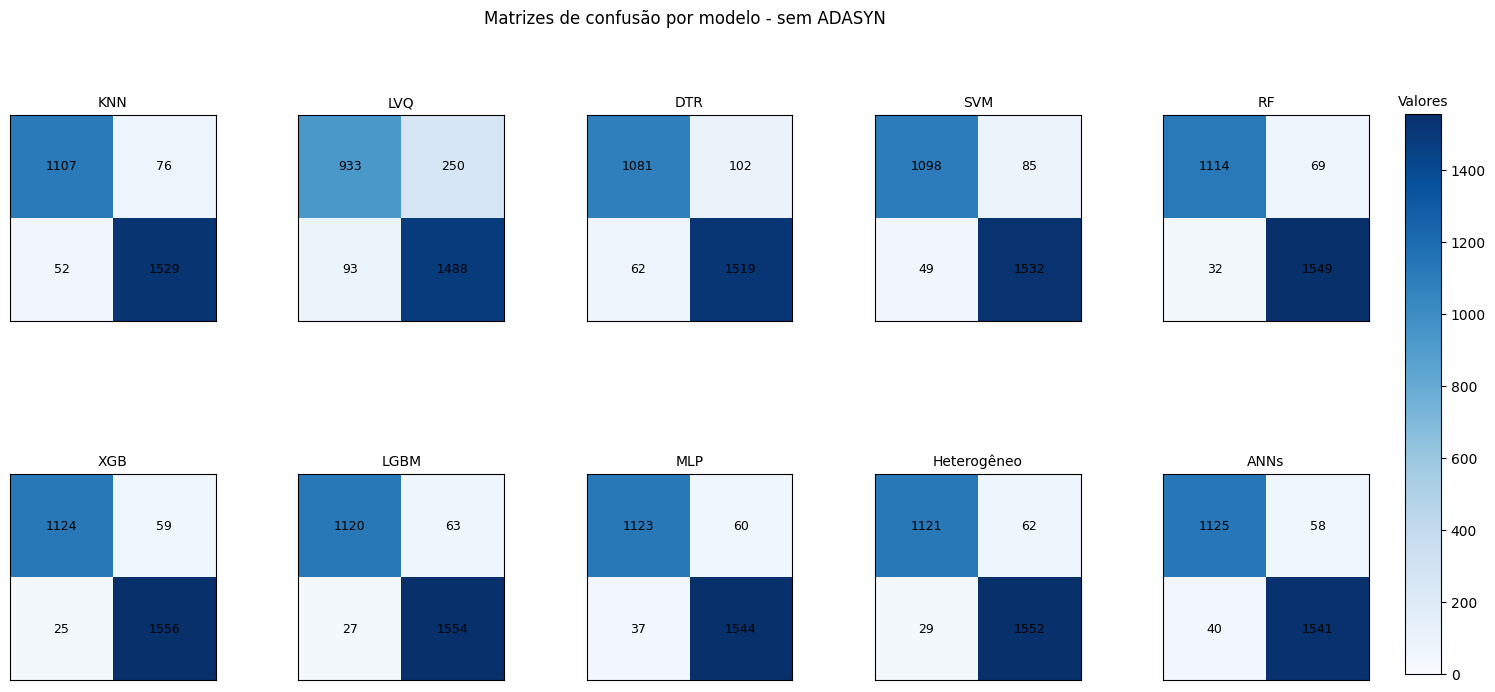

In [26]:
confusion_matrices = test_metrics_no_adasyn['CM']
models = test_metrics_no_adasyn['model_name']

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.subplots_adjust(right=0.88, wspace=0.4, hspace=0.4)

vmin, vmax = 0, max(np.max(cm) for cm in confusion_matrices)
for ax, cm, model in zip(axes.ravel(), confusion_matrices, models):
    im = ax.imshow(cm, cmap="Blues", vmin=vmin, vmax=vmax)
    ax.set_title(model, fontsize=10)
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(j, i, cm[i][j], ha="center", va="center", color="black", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar_ax.set_title("Valores", fontsize=10)
fig.suptitle('Matrizes de confusão por modelo - sem ADASYN')

plt.show()

# With adasyn

In [10]:
test_metrics_with_adasyn = stress_testing(X_train, y_train, X_test, y_test, best_pipelines, use_adasyn=True)
test_metrics_with_adasyn

Model KNN
Model LVQ
Model DTR
Model SVM


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Model RF
Model XGB
Model LGBM
[LightGBM] [Info] Number of positive: 4576, number of negative: 4790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 9366, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488576 -> initscore=-0.045705
[LightGBM] [Info] Start training from score -0.045705
Model MLP
Model Heterogêneo
Model ANNs

 Metrics: 
    model_name      ACSA    recall                         CM  f1_score  \
0          KNN  0.957782  0.959519   [[1131, 52], [64, 1517]]  0.963175   
1          LVQ  0.845428  0.715370  [[1154, 29], [450, 1131]]  0.825246   
2          DTR  0.938795  0.931689  [[1119, 64], [108, 1473]]  0.944836   
3          SVM  0.951131  0.953827   [[1122, 61], [73, 1508]]  0.9

,model_name,ACSA,recall,CM,f1_score,training_time,inference_time,error_rate,train_accuracy,test_accuracy,precision
0,KNN,0.957782,0.959519,"[[1131, 52], [64, 1517]]",0.963175,0.107822,0.405144,0.041968,0.987615,0.958032,0.966858
1,LVQ,0.845428,0.715370,"[[1154, 29], [450, 1131]]",0.825246,10.771592,0.126829,0.173300,0.851591,0.826700,0.975000
2,DTR,0.938795,0.931689,"[[1119, 64], [108, 1473]]",0.944836,0.352965,0.008196,0.062229,0.928251,0.937771,0.958360
3,SVM,0.951131,0.953827,"[[1122, 61], [73, 1508]]",0.957460,2.745637,3.692270,0.048480,0.963165,0.951520,0.961122
4,RF,0.961801,0.955724,"[[1145, 38], [70, 1511]]",0.965495,1.684193,0.080205,0.039074,0.978326,0.960926,0.975468
5,XGB,0.963796,0.966477,"[[1137, 46], [53, 1528]]",0.968621,1.792416,0.017143,0.035818,0.986440,0.964182,0.970775
6,LGBM,0.965590,0.968374,"[[1139, 44], [50, 1531]]",0.970215,0.970200,0.000172,0.034009,0.986974,0.965991,0.972063
7,MLP,0.959047,0.962049,"[[1131, 52], [60, 1521]]",0.964490,32.134419,0.000000,0.040521,0.987401,0.959479,0.966942
8,Heterogêneo,0.965697,0.967742,"[[1140, 43], [51, 1530]]",0.970197,3.655425,0.531583,0.034009,0.987615,0.965991,0.972664
9,ANNs,0.963477,0.968374,"[[1134, 49], [50, 1531]]",0.968681,77.593475,0.017372,0.035818,0.987828,0.964182,0.968987


In [21]:
confusion_matrices = test_metrics_with_adasyn['CM']
models = test_metrics_with_adasyn['model_name']

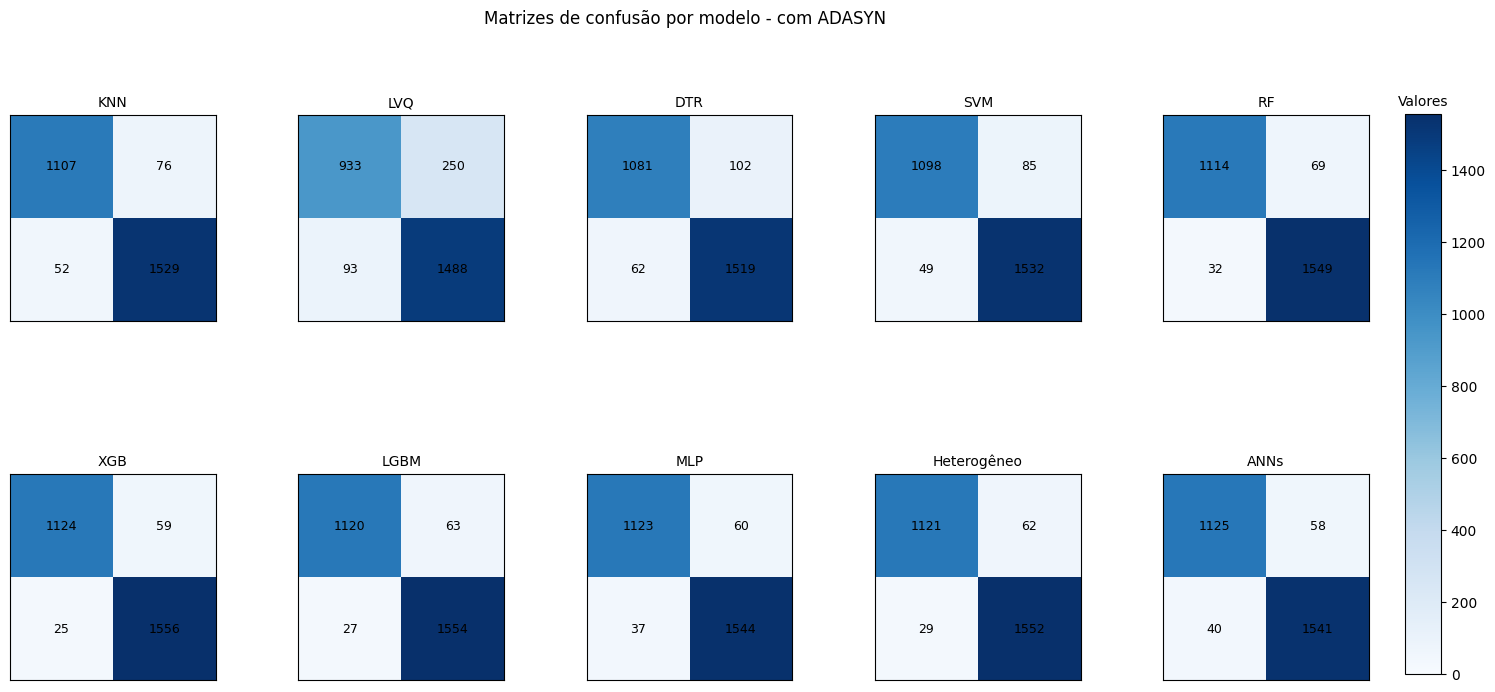

In [29]:
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.subplots_adjust(right=0.88, wspace=0.4, hspace=0.4)

vmin, vmax = 0, max(np.max(cm) for cm in confusion_matrices)
for ax, cm, model in zip(axes.ravel(), confusion_matrices, models):
    im = ax.imshow(cm, cmap="Blues", vmin=vmin, vmax=vmax)
    ax.set_title(model, fontsize=10)
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(j, i, cm[i][j], ha="center", va="center", color="black", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar_ax.set_title("Valores", fontsize=10)
fig.suptitle('Matrizes de confusão por modelo - com ADASYN')

plt.show()

## Wilcoxon

In [18]:
from scipy.stats import ttest_rel, wilcoxon

list_of_metrics_names = ['ACSA', 'recall', 'f1_score', 'test_accuracy', 'train_accuracy', 'precision', 'inference_time', 'training_time']
list_of_statistics = []
list_of_pvalues = []
list_of_diff_flags = []
list_of_means_with_adasyn = []
list_of_means_no_adasyn = []

for metric in list_of_metrics_names:
    statistic, p_value = wilcoxon(test_metrics_no_adasyn[metric],test_metrics_with_adasyn[metric])
    if p_value < 0.05:
        are_different = True
    else:
        are_different = False
    
    list_of_statistics.append(statistic)
    list_of_pvalues.append(p_value)
    list_of_diff_flags.append(are_different)
    list_of_means_no_adasyn.append(test_metrics_no_adasyn[metric].mean())
    list_of_means_with_adasyn.append(test_metrics_with_adasyn[metric].mean())

wilcoxon_dict = {
    'metric': list_of_metrics_names,
    'statistic': list_of_statistics,
    'mean_with_adasyn': list_of_means_with_adasyn,
    'mean_no_adasyn': list_of_means_no_adasyn,
    'p-value': list_of_pvalues,
    'are_different': list_of_diff_flags
}

wilcoxon_results = pd.DataFrame(wilcoxon_dict)

metrics_with_difference = wilcoxon_results[wilcoxon_results['are_different'] == True]['metric'].tolist()

In [19]:
wilcoxon_results

,metric,statistic,mean_with_adasyn,mean_no_adasyn,p-value,are_different
0,ACSA,25.0,0.947254,0.948532,0.845703,False
1,recall,0.0,0.934915,0.971790,0.001953,True
2,f1_score,6.0,0.949842,0.958761,0.027344,True
3,test_accuracy,6.0,0.945478,0.951881,0.050612,False
4,train_accuracy,0.0,0.964521,0.970245,0.001953,True
5,precision,0.0,0.968824,0.946308,0.001953,True
6,inference_time,23.0,0.487891,0.131941,0.695312,False
7,training_time,9.0,13.180814,12.858553,0.064453,False
